We fetch data from http://ai.stanford.edu/~amaas/data/sentiment/.

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

In [1]:
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

def review_to_wordlist(review, remove_stopwords=False):
    review_text = BeautifulSoup(review, 'lxml').get_text()
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    words = review_text.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return words

In [69]:
import re 
from six.moves import xrange
import os

def get_data(file_dirs, remove_stopwords=False):
    label = []
    txt = []
    comp_re = re.compile('(\d+)_(\d+).txt')
    for file_dir in file_dirs:
        name_list = [x for x in os.listdir(file_dir) if '.txt' in x]
        for x in iter(name_list):
            f = open(os.path.join(file_dir, x), 'r')
            word_list = review_to_wordlist(f.read(),  remove_stopwords)
            txt.append(word_list)
            f.close()
            obj = comp_re.search(x)
            label.append(float(obj.group(2)))
    return [txt, label]

In [70]:
%%time
train_unlabeled = get_data(['./aclImdb/train/unsup'], remove_stopwords=True)

CPU times: user 1min 20s, sys: 14.4 s, total: 1min 35s
Wall time: 2min 51s


In [71]:
%%time
train_labeled = get_data(['./aclImdb/train/pos', './aclImdb/train/neg'], remove_stopwords=True)

CPU times: user 41 s, sys: 9.93 s, total: 50.9 s
Wall time: 1min 30s


In [6]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = "word", 
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 5000) 

In [17]:
def make_BoW(vectorizer, data):
    _data = []
    for x in data:
        _data.append(' '.join(x))
    transfomed_data = vectorizer.fit_transform(_data) 
    return transfomed_data

In [27]:
%%time

bow = make_BoW(vectorizer, labeled_data[0])

CPU times: user 4.24 s, sys: 159 ms, total: 4.4 s
Wall time: 4.51 s


In [30]:
import numpy as np

voc = vectorizer.get_feature_names()

In [33]:
from sklearn.preprocessing import normalize

bow = normalize(bow, norm='l2', axis=1)

/Users/tomoaki/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [34]:
np.max(bow)

0.86692144686301076

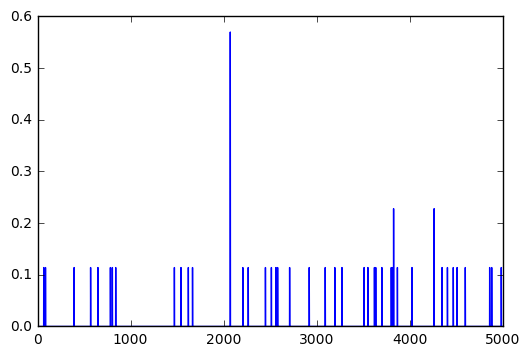

In [44]:
plt.plot(bow.toarray()[0])

In [51]:
%%time

from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 
forest.fit(bow, labeled_data[1])

CPU times: user 2min 27s, sys: 2.26 s, total: 2min 29s
Wall time: 2min 39s


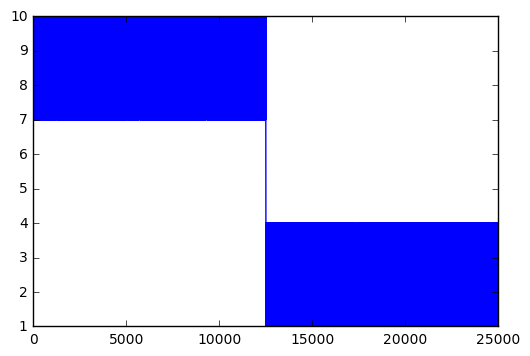

In [52]:
plt.plot(forest.predict(bow))

In [53]:
%%time
test_data = get_data(['./aclImdb/test/pos', './aclImdb/test/neg'], remove_stopwords=True)

CPU times: user 36.3 s, sys: 8.36 s, total: 44.6 s
Wall time: 2min


In [60]:
test_input, test_label = test_data
# vectorizer.fit([' '.join(x)  for x in labeled_data[0]])
test_bow = vectorizer.transform([' '.join(x)  for x in test_input])

In [63]:
output = forest.predict(test_bow)

In [67]:
type(output[0])

numpy.str_

In [2]:
import pandas as pd
data = pd.read_csv("train.tsv", header=0, delimiter="\t")

In [3]:
import os

In [5]:
os.listdir()

['.ipynb_checkpoints', 'aclImdb', 'word2vec.ipynb']

In [2]:
import nltk
import warnings

warnings.filterwarnings("ignore")
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [7]:
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re

def review_to_wordlist(review, remove_stopwords=False):
    review_text = BeautifulSoup(review).get_text()
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    words = review_text.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words('english'))
        words = [w for w in words if not w in stops]
    return words

def review_to_sentences(review, tokenizer, remove_stopwords=False):
    raw_sentences = tokenizer.tokenize(review)
    sentences = [review_to_wordlist(s) for s in raw_sentences]
    return sentences

In [8]:

sentences = []
for review in unlabeled_train['review']:
    sentences += review_to_sentences(review, tokenizer)

for review in train['review']:
    sentences += review_to_sentences(review, tokenizer)

In [9]:
print(len(sentences))

795538


weights = model.syn0
np.save(open("embbeding.npy", 'wb'), weights)

In [10]:
from keras.layers import Embedding, Input

def w2v_embedding_layer(embeddings_path):
    weights = np.load(open(embeddings_path, 'rb'))
    layer = Embedding(input_dim=weights.shape[0], 
                      output_dim=weights.shape[1], 
                      weights=[weights])
    return layer

Using TensorFlow backend.


In [70]:
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D 
from keras.layers.core import Flatten, Lambda
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers.core import Dense
from keras.layers.advanced_activations import PReLU
from keras.layers import SpatialDropout2D
from keras.layers import Dropout, Reshape
from keras.layers import Embedding
from keras import backend as K
import numpy as np
import pandas as pd
import time
from gensim.models.word2vec import Word2Vec

class CNN(object):
    def __init__(self, conf, sentences):
        self.n_output = conf.n_output
        self.n_feature = conf.n_feature
        self.k_w = conf.k_w
        self.n_emb = conf.n_emb
        self.min_word_count = conf.min_word_count
        self.n_context = conf.n_context
        self.n_workers = 4
        self.algo = conf.algo
        self.n_epoch = conf.n_epoch
        self.batch_size = conf.batch_size
        
        print("build word2vec ...")
        self.word2vec = model = Word2Vec(sentences, workers=self.n_workers, 
            size=self.n_emb, min_count = self.min_word_count, 
            window = self.n_context, sg=self.algo)
        print("finished!")
        
        self.vocab = dict([(k, v.index) for k, v in self.word2vec.vocab.items()])
        self.n_vocab = len(self.vocab)
        self.maxlen = None
        index = self.word2index(sentences)
        self.maxlen = len(index[0])
        
        # avoid creating _LEARNING_PHASE outside the network
        tf.reset_default_graph()
        K.clear_session()
        self.sess = tf.Session()
        print("buiild model ...")
        self.build_model()
        print("finished")
        
    def train(self, input_data, target_data):
        print("start training")
        index_data = self.word2index(input_data)
        self.model.fit(index_data, target_data, nb_epoch=self.n_epoch, batch_size=self.batch_size)
        print("finished")
        
    def predict(self, input_data):
        index_data = self.word2index(input_data)
        return self.model.predict(index_data)
        
    def word2index(self, sentences):
        index = []
        for sentence in iter(sentences):
            index.append([self.vocab[w] for w in sentence if w in self.vocab.keys()])
        return pad_sequences(index, maxlen=self.maxlen)
    
    def build_model(self):
        self.input = tf.placeholder(tf.int32, [None, self.maxlen], name="input")
        self.model = self.build_cnn()
        self.output = self.model(self.input)
        self.model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
    
    def build_cnn(self):
        """Build network"""
        model = Sequential()
        # embedding
        model.add(Embedding(input_dim=self.n_vocab, output_dim=self.n_emb, 
                            input_length=self.maxlen, name="embedding", weights=[self.word2vec.syn0]))
        model.add(Reshape([self.maxlen, self.n_emb, 1]))
        # layer 1
        nf = self.n_feature
        model.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, 
                                border_mode='same', name="layer1"))
        model.add(BatchNormalization(mode=2, axis=-1))
        model.add(PReLU())
        model.add(MaxPooling2D(pool_size=(2, 1), strides=None))
        # layer2
        nf = nf * 2
        model.add(Convolution2D(nb_filter=nf, nb_row=self.k_w, nb_col=1, 
                                border_mode='same', name="layer2"))
        model.add(BatchNormalization(mode=2, axis=-1))
        model.add(PReLU())
        model.add(MaxPooling2D(pool_size=(2, 1), strides=None))
        model.add(Flatten())
        # layer3
        model.add(Dense(self.n_output, activation="sigmoid",
                       name="output_layer"))
        # model.add(BatchNormalization(mode=1, axis=-1))
        return model
        
        
        

In [83]:
class Config(object):
    n_output = 1
    n_feature = 100
    n_emb = 100
    k_w = 5
    min_word_count = 1
    n_context = 10
    n_worker = 4
    algo = 1
    n_epoch=1
    batch_size = 64

In [85]:
target_data = train["sentiment"]
cnn = CNN(conf, sentences)
cnn.train(sentences, target_data)

build word2vec ...


KeyboardInterrupt: 

In [1]:
import sys


In [2]:
sys.path

['',
 '/Users/admin/pokemon/PokemonGo-Bot/src/pgoapi',
 '/Users/admin/anaconda/lib/python35.zip',
 '/Users/admin/anaconda/lib/python3.5',
 '/Users/admin/anaconda/lib/python3.5/plat-darwin',
 '/Users/admin/anaconda/lib/python3.5/lib-dynload',
 '/Users/admin/anaconda/lib/python3.5/site-packages',
 '/Users/admin/anaconda/lib/python3.5/site-packages/Sphinx-1.3.5-py3.5.egg',
 '/Users/admin/anaconda/lib/python3.5/site-packages/aeosa',
 '/Users/admin/anaconda/lib/python3.5/site-packages/IPython/extensions',
 '/Users/admin/.ipython']

In [3]:
!which python


/Users/admin/anaconda/bin/python


In [4]:
import os
os.environ['PYTHONPATH'].split(os.pathsep)

KeyError: 'PYTHONPATH'